In [6]:
# pip install pygeoip
# pip install fastparquet 
# pip install dnspython
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import datetime
import matplotlib.pyplot as plt 

datafile='./test7.parquet'

### IP geolocalization
gi=pygeoip.GeoIP('./GeoIP.dat')
gi2=pygeoip.GeoIP('./GeoIPASNum.dat')
""" addr='193.136.73.21'
cc=gi.country_code_by_addr(addr)
org=gi2.org_by_addr(addr)
print(cc,org) """

### DNS resolution
""" addr=dns.resolver.resolve("www.ua.pt", 'A')
for a in addr:
    print(a) """
    
### Reverse DNS resolution    
name=dns.reversename.from_address("193.136.172.20")
addr=dns.resolver.resolve(name, 'PTR')

udpF=data.loc[data['proto']=='udp']

#Number of UDP flows for each source IP
nudpF=data.loc[data['proto']=='udp'].groupby(['src_ip'])['up_bytes'].count()

nudpF=data.loc[data['port']==443].groupby(['src_ip'])['up_bytes'].sum().sort_values()


#Number of UDP flows to port 443, for each source IP
nudpF443=data.loc[(data['proto']=='udp')&(data['port']==443)].groupby(['src_ip'])['up_bytes'].count() 

#Average number of downloaded bytes, per flow, for each source IP
avgUp=data.groupby(['src_ip'])['down_bytes'].mean()
print(avgUp.sort_values())



src_ip
192.168.107.20       9225.564136
192.168.107.160     12310.309688
192.168.107.152     59226.634717
192.168.107.127     78836.798314
192.168.107.36      84253.278912
                       ...      
192.168.107.57     100789.442052
192.168.107.72     102768.417439
192.168.107.104    102805.031590
192.168.107.188    103460.579196
192.168.107.109    104173.192488
Name: down_bytes, Length: 197, dtype: float64


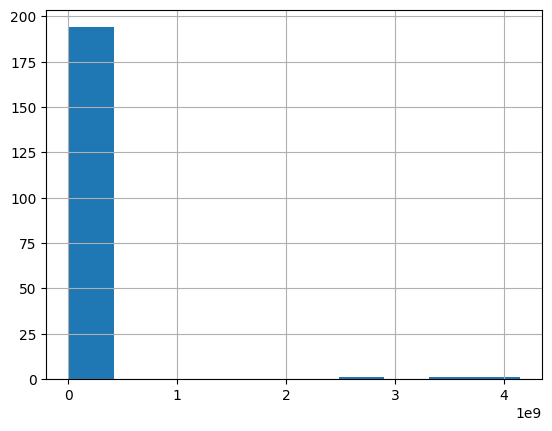

In [7]:

#Total uploaded bytes to destination port 443, for each source IP, ordered from larger amount to lowest amount
upS=data.loc[((data['port']==443))].groupby(['src_ip'])['up_bytes'].sum().sort_values(ascending=False)

#Histogram of the total uploaded bytes to destination port 443, by source IP
upS=data.loc[((data['port']==443))].groupby(['src_ip'])['up_bytes'].sum().hist()
plt.show()

#Is destination IPv4 a public address?
NET=ipaddress.IPv4Network('192.168.103.0/24')
bpublic=data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1) 
#Geolocalization of public destination adddress
cc=data[bpublic]['dst_ip'].apply(lambda y:gi.country_code_by_addr(y)).to_frame(name='cc') 

